# Análisis y preprocesamiento de los datos extraídos

In [39]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from array import *
from pickle import dump
import math

import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(123)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Carga de los datos en DataFrame

In [40]:
FILEPATH = "datasources/THC-id-17-original.csv"
df = pd.read_csv(FILEPATH, parse_dates=True)

In [41]:
df

,datetime,id,value
0,2019-01-01 03:00:00,17.0,0.087
1,2019-01-01 03:15:00,17.0,0.100
2,2019-01-01 03:30:00,17.0,0.084
3,2019-01-01 03:45:00,17.0,0.057
4,2019-01-01 04:00:00,17.0,0.167
...,...,...,...
64451,2020-11-03 22:00:00,17.0,0.031
64452,2020-11-03 22:15:00,17.0,0.055
64453,2020-11-03 22:30:00,17.0,0.019
64454,2020-11-03 22:45:00,17.0,0.021


### Análisis estadístico de los datos

In [42]:
df.describe(percentiles=[.25, .5, .75, .95])

,id,value
count,64456.0,64456.000000
mean,17.0,0.056218
std,0.0,0.083212
min,17.0,0.000000
25%,17.0,0.016000
50%,17.0,0.031000
75%,17.0,0.052000
95%,17.0,0.241000
max,17.0,0.676000


### Se comprueba que no existe ningún valor nulo por lo que no se requiere ningún tratamiento especial para este tipo de datos

In [43]:
df.isna().sum()

datetime    0
id          0
value       0
dtype: int64

### Se ve que en algunas ocasiones, no se ha producido una medición, ya puede ser por un fallo del medidor o un corte eléctrico, por ejemplo para el 11 de diciembre de 2019, no hubo mediciones entre las 9 y las 11 y 15. Para solucionar esto, rellenaremos estos valores con la media de todos los valores.

#### El proceso será pasar la fecha a Timestamp y desde el primer timestamp con pasos de 900 que son los segundos que pasan cada 15 min se comprueba si existe el timestamp en el dataframe y si no existe se rellena el valor con la media

In [44]:
df.iloc[33000:33010]

,datetime,id,value
33000,2019-12-11 07:15:00,17.0,0.034
33001,2019-12-11 07:30:00,17.0,0.005
33002,2019-12-11 07:45:00,17.0,0.032
33003,2019-12-11 08:00:00,17.0,0.041
33004,2019-12-11 08:15:00,17.0,0.018
33005,2019-12-11 08:30:00,17.0,0.017
33006,2019-12-11 08:45:00,17.0,0.041
33007,2019-12-11 09:00:00,17.0,0.027
33008,2019-12-11 11:15:00,17.0,0.040
33009,2019-12-11 11:30:00,17.0,0.017


In [45]:
df['datetime'] = df['datetime'].apply(lambda x: int(pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S").timestamp()))

In [46]:
min_ts = int(df.iloc[0]['datetime'])
max_ts = int(df.iloc[-1]['datetime'])
intervalo = 900
lista_anyadir = []

for i in range(min_ts, max_ts + intervalo, intervalo):
    if i not in df.datetime.values:
        lista_anyadir.append([i, 17.0, np.nan])
        
lista_anyadir

[[1564391700, 17.0, nan],
 [1564392600, 17.0, nan],
 [1564393500, 17.0, nan],
 [1564394400, 17.0, nan],
 [1564395300, 17.0, nan],
 [1564396200, 17.0, nan],
 [1564397100, 17.0, nan],
 [1564398000, 17.0, nan],
 [1564398900, 17.0, nan],
 [1564399800, 17.0, nan],
 [1564400700, 17.0, nan],
 [1564401600, 17.0, nan],
 [1564402500, 17.0, nan],
 [1564403400, 17.0, nan],
 [1564404300, 17.0, nan],
 [1564405200, 17.0, nan],
 [1564406100, 17.0, nan],
 [1564407000, 17.0, nan],
 [1564407900, 17.0, nan],
 [1564408800, 17.0, nan],
 [1564409700, 17.0, nan],
 [1564410600, 17.0, nan],
 [1564411500, 17.0, nan],
 [1564412400, 17.0, nan],
 [1566206100, 17.0, nan],
 [1566207000, 17.0, nan],
 [1566207900, 17.0, nan],
 [1566208800, 17.0, nan],
 [1566209700, 17.0, nan],
 [1566210600, 17.0, nan],
 [1566211500, 17.0, nan],
 [1566212400, 17.0, nan],
 [1566213300, 17.0, nan],
 [1566214200, 17.0, nan],
 [1566215100, 17.0, nan],
 [1566216000, 17.0, nan],
 [1566216900, 17.0, nan],
 [1566217800, 17.0, nan],
 [1566218700

In [47]:
df = pd.concat([df, pd.DataFrame(lista_anyadir, columns=['datetime', 'id', 'value'])], ignore_index=True, axis=0).sort_values('datetime')

In [48]:
df['datetime'] = df['datetime'].apply(lambda x: pd.Timestamp(x, unit='s').strftime("%Y-%m-%d %H:%M:%S"))

In [49]:
df

,datetime,id,value
0,2019-01-01 03:00:00,17.0,0.087
1,2019-01-01 03:15:00,17.0,0.100
2,2019-01-01 03:30:00,17.0,0.084
3,2019-01-01 03:45:00,17.0,0.057
4,2019-01-01 04:00:00,17.0,0.167
...,...,...,...
64451,2020-11-03 22:00:00,17.0,0.031
64452,2020-11-03 22:15:00,17.0,0.055
64453,2020-11-03 22:30:00,17.0,0.019
64454,2020-11-03 22:45:00,17.0,0.021


#### Interpolamos los valores a none

In [50]:
df['value'] = df['value'].interpolate()

#### Mostramos los valores anteriores y vemos como se ha rellenado correctamente

In [51]:
df = df.reset_index(drop=True)

In [52]:
df.iloc[33041:33060]

,datetime,id,value
33041,2019-12-11 07:15:00,17.0,0.034000
33042,2019-12-11 07:30:00,17.0,0.005000
33043,2019-12-11 07:45:00,17.0,0.032000
33044,2019-12-11 08:00:00,17.0,0.041000
33045,2019-12-11 08:15:00,17.0,0.018000
33046,2019-12-11 08:30:00,17.0,0.017000
33047,2019-12-11 08:45:00,17.0,0.041000
33048,2019-12-11 09:00:00,17.0,0.027000
33049,2019-12-11 09:15:00,17.0,0.028444
33050,2019-12-11 09:30:00,17.0,0.029889


In [53]:
df.to_csv('datasources/THC-id-17.csv', index=False)

### La columna id se repite siempre en todas las filas y no representa una característica útil para el modelo, por lo que se elimina del DataFrame

In [54]:
df = pd.DataFrame(df, columns=['datetime', 'value'])
df

,datetime,value
0,2019-01-01 03:00:00,0.087
1,2019-01-01 03:15:00,0.100
2,2019-01-01 03:30:00,0.084
3,2019-01-01 03:45:00,0.057
4,2019-01-01 04:00:00,0.167
...,...,...
64588,2020-11-03 22:00:00,0.031
64589,2020-11-03 22:15:00,0.055
64590,2020-11-03 22:30:00,0.019
64591,2020-11-03 22:45:00,0.021


### El campo datetime tampoco supone una entrada válida para el modelo en este formato ni en formato timestamp, por lo se construyen ondas longitudinales con el seno y el coseno para establecer características a los datos según el momento del tiempo que representa. De esta forma se pueden relacionar las horas de distintos días, por ejemplo, un día cualquiera va a tener el mismo seno y coseno a las 12:00h que al día siguiente o cualquiera a las 12:00h. 

In [55]:
med_hour = 4
med_day = 4 * 24
med_week = med_day * 7
med_month = med_day * 31      # Aprox un mes
med_year = med_day * 365      # Aprox un año

data_plot = np.array(df['value'])

### Para obtener que referencias son más importantes se analizan los cambios que se producen durante un día, una semana, un mes y un año

#### Por ejemplo, al comparar el primer día del dataset con el segundo día vemos que mantienen una relación en las primeras horas del día, y un pico en el medio día y otro al final del día, por lo que la hora representada en seno y coseno puede ser un valor importante.

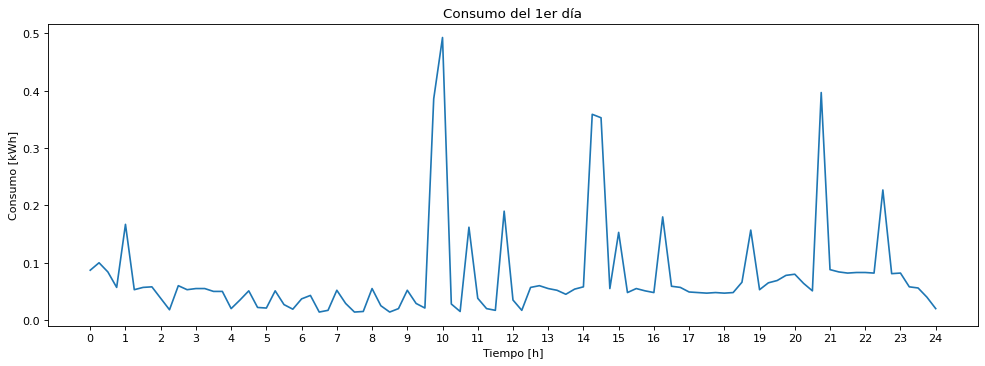

In [56]:
index = np.arange(0, 24.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[:med_day+1])
plt.xticks(range(0, 25, 1))
plt.xlabel('Tiempo [h]') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del 1er día')
plt.show()

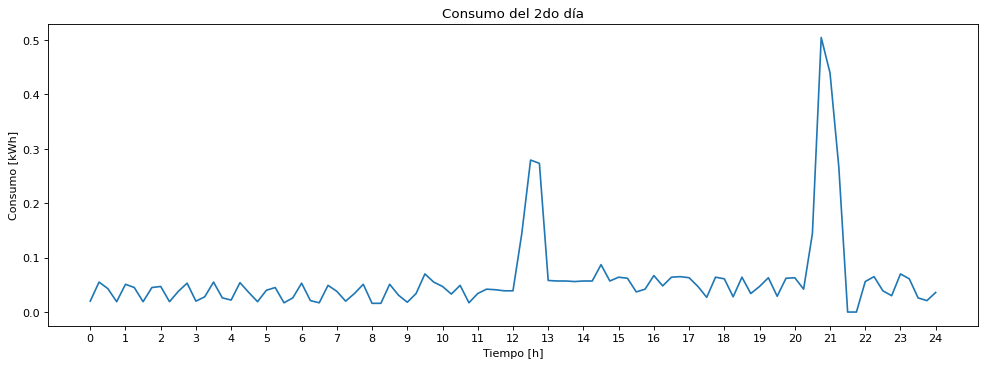

In [57]:
index = np.arange(24, 48.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[med_day: (2 * med_day) + 1])
plt.xticks(range(24, 49, 1), range(0,25))
plt.xlabel('Tiempo [h]') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del 2do día')
plt.show()

#### NOTA: 01-01-2019 fue martes.
#### Al comparar las dos primeras semanas, vemos que las dos se comportan de manera parecida, teniendo un consumo más abundante en los días lunes, martes, viernes y domingo y menos abundates en los días miércoles, jueves y sábado por lo que será una característica a tener en cuenta también.

In [58]:
med_week

672

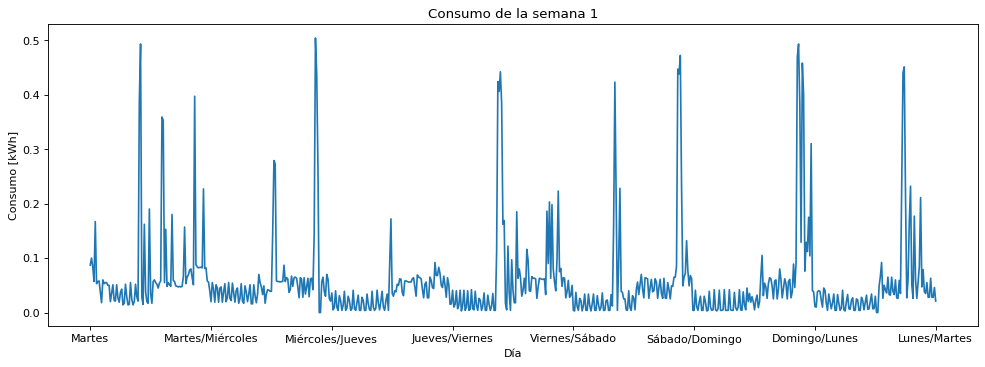

In [59]:
index = np.arange(0, 168.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[:med_week + 1])
myticks = ['Martes','Martes/Miércoles','Miércoles/Jueves', 'Jueves/Viernes', 
           'Viernes/Sábado', 'Sábado/Domingo','Domingo/Lunes', 'Lunes/Martes']
plt.xticks(range(0, 169, 24), myticks)
plt.xlabel('Día') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo de la semana 1')
plt.show()

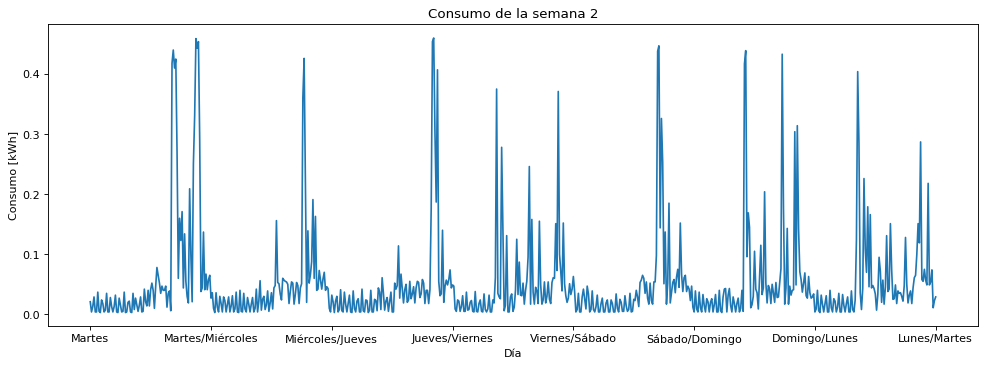

In [60]:
index = np.arange(168, 336.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[med_week:(med_week*2) + 1])
myticks = ['Martes','Martes/Miércoles','Miércoles/Jueves', 'Jueves/Viernes', 
           'Viernes/Sábado', 'Sábado/Domingo','Domingo/Lunes', 'Lunes/Martes']
plt.xticks(range(168, 337, 24), myticks)
plt.xlabel('Día') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo de la semana 2')
plt.show()

#### Sin embargo, el día del mes parece que no es una característica relevante. Para ponerse en situación, esto comprueba si hay alguna relación o característica especial entre el consumo a principios de mes o a final de mes pero parece que no la hay.

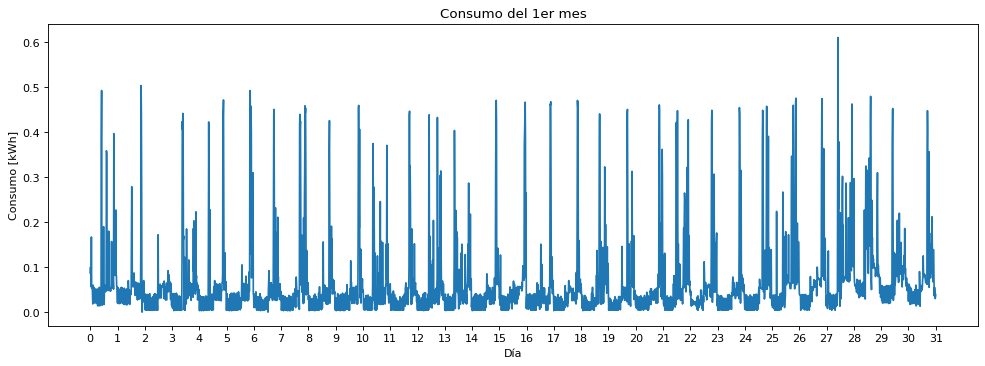

In [61]:
index = np.arange(0, 744.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[:med_month + 1])
plt.xticks(range(0, 745, 24), range(0,32))
plt.xlabel('Día') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del 1er mes')
plt.show()

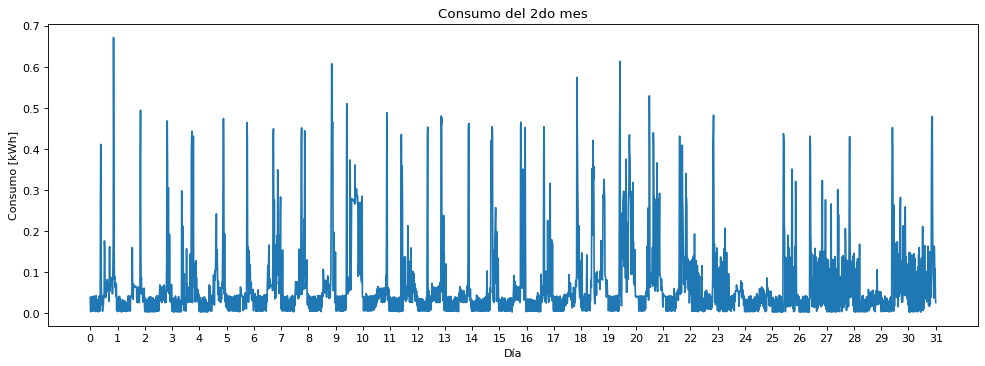

In [62]:
index = np.arange(0, 744.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[med_month : (2 * med_month) + 1])
plt.xticks(range(0, 745, 24), range(0,32))
plt.xlabel('Día') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del 2do mes')
plt.show()

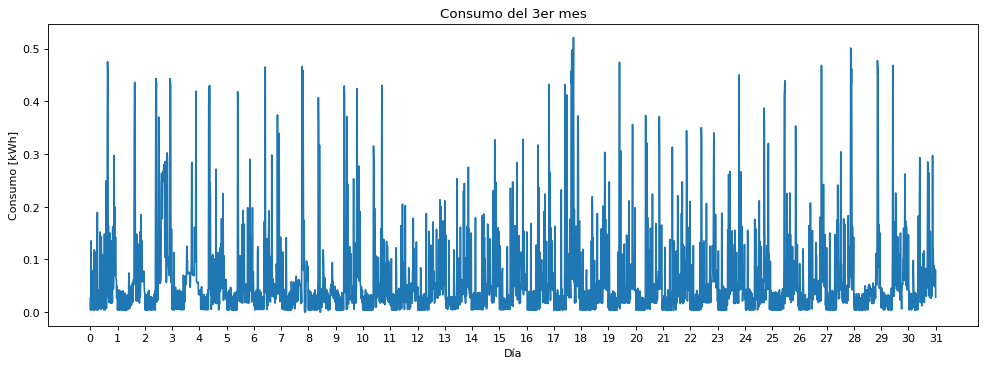

In [63]:
index = np.arange(0, 744.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[(2 * med_month) : (3 * med_month) + 1])
plt.xticks(range(0, 745, 24), range(0,32))
plt.xlabel('Día') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del 3er mes')
plt.show()

#### Al observar todas las mediciones del año, se puede observar que el consumo aumenta en el principio de año que suele ser los meses más fríos, y en los meses de la mitad que pueden representar julio y agosto,  cuando es verano y son los meses más calurosos por lo que saber en que parte del año se ha producido la medición también es una característica importante.

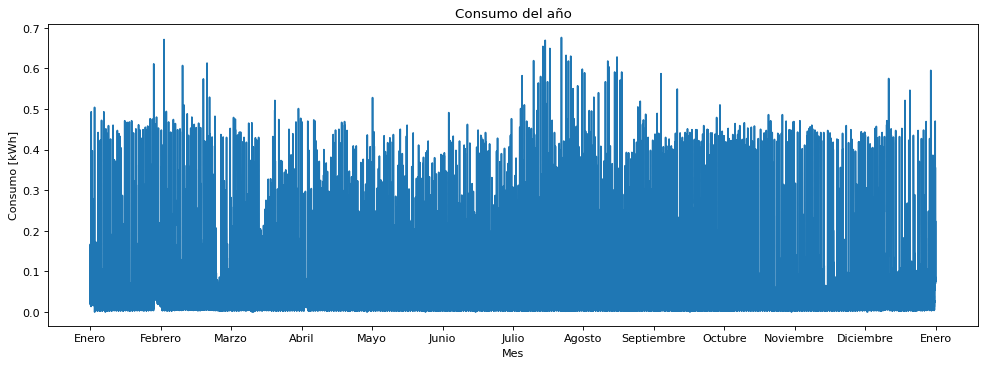

In [64]:
index = np.arange(0, 8760.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, data_plot[:med_year + 1])
myticks = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 
           'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Enero']
plt.xticks(range(0, 8761, 730), myticks)
plt.xlabel('Mes') 
plt.ylabel('Consumo [kWh]') 
plt.title('Consumo del año')
plt.show()

### Una vez analizados qué características de la fecha son más relevantes para predecir el consumo se producen las transformaciones a seno y coseno. Para ello se llama a la función de numpy de seno y coseno dividiendo el timestamp entre los segundos de cada característica, por ejemplo, del día, se dividiría el timestamp entre los segundos de un día y luego se pasa a radianes multiplicando 2 * pi. En este caso las características serán el día, la semana y el año para saber en que momento de la característica está para apoyar a la predicción, es decir, que el objetivo sería decirle al modelo por ejemplo que la medición se produjo en las primeras horas del día de los días finales de una semana en mitad de año, o más bien dicho, a las 2 de la mañana de un domingo de julio. 

In [65]:
date_time = pd.to_datetime(df.pop('datetime'), format='%Y-%m-%d %H:%M:%S')

In [66]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [67]:
day = 24*60*60
week = 7 * day
month = (30.4167)*day
year = (365.2425)*day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [68]:
df

,value,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
0,0.087,0.707107,0.707107,-0.993712,-0.111964,0.004172,0.999991
1,0.100,0.751840,0.659346,-0.994716,-0.102669,0.004351,0.999991
2,0.084,0.793353,0.608761,-0.995632,-0.093364,0.004530,0.999990
3,0.057,0.831470,0.555570,-0.996461,-0.084051,0.004709,0.999989
4,0.167,0.866025,0.500000,-0.997204,-0.074730,0.004888,0.999988
...,...,...,...,...,...,...,...
64588,0.031,-0.500000,0.866025,-0.826239,0.563320,-0.835100,0.550099
64589,0.055,-0.442289,0.896873,-0.820936,0.571021,-0.835001,0.550248
64590,0.019,-0.382683,0.923880,-0.815561,0.578671,-0.834902,0.550398
64591,0.021,-0.321439,0.946930,-0.810115,0.586271,-0.834804,0.550548


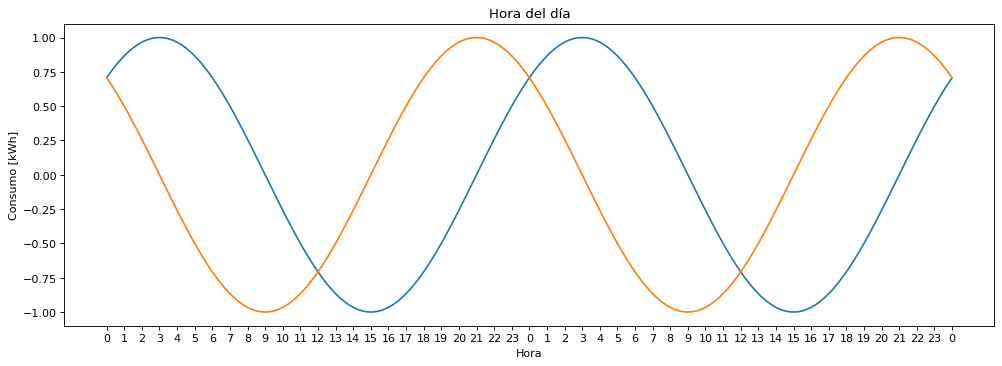

In [69]:
index = np.arange(0, 48.25, .25)
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(index, np.array(df['day_sin'])[:193])
plt.plot(index, np.array(df['day_cos'])[:193])
myticks = list(range(0,24)) + list(range(0,24)) + [0]
plt.xticks(range(0, 49, 1), myticks)
plt.xlabel('Hora') 
plt.ylabel('Consumo [kWh]') 
plt.title('Hora del día')
plt.show()

Text(0.5, 1.0, 'Momento de la semana')

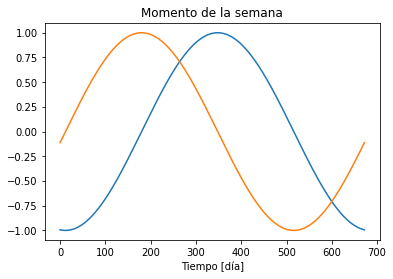

In [70]:
plt.plot(np.array(df['week_sin'])[:673])
plt.plot(np.array(df['week_cos'])[:673])
plt.xlabel('Tiempo [día]') 
plt.title('Momento de la semana')

Text(0.5, 1.0, 'Momento del año')

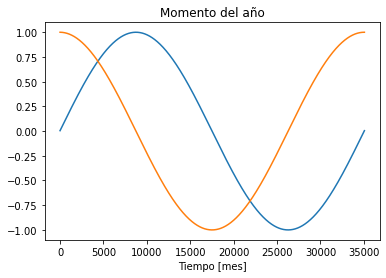

In [71]:
plt.plot(np.array(df['year_sin'])[:35064])
plt.plot(np.array(df['year_cos'])[:35064])
plt.xlabel('Tiempo [mes]') 
plt.title('Momento del año')

In [72]:
df = pd.DataFrame(df, columns = ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'value'])
df

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,value
0,0.707107,0.707107,-0.993712,-0.111964,0.004172,0.999991,0.087
1,0.751840,0.659346,-0.994716,-0.102669,0.004351,0.999991,0.100
2,0.793353,0.608761,-0.995632,-0.093364,0.004530,0.999990,0.084
3,0.831470,0.555570,-0.996461,-0.084051,0.004709,0.999989,0.057
4,0.866025,0.500000,-0.997204,-0.074730,0.004888,0.999988,0.167
...,...,...,...,...,...,...,...
64588,-0.500000,0.866025,-0.826239,0.563320,-0.835100,0.550099,0.031
64589,-0.442289,0.896873,-0.820936,0.571021,-0.835001,0.550248,0.055
64590,-0.382683,0.923880,-0.815561,0.578671,-0.834902,0.550398,0.019
64591,-0.321439,0.946930,-0.810115,0.586271,-0.834804,0.550548,0.021


### Una vez preprocesado el dataset, se guarda en otro fichero csv referente a su limpiado y preprocesado para utilizarlo en los posteriores modelos de predicción

In [73]:
df.to_csv('datasources/THC-id-17-preprocessed.csv', index=False)

In [74]:
df['value'].std(ddof=0)

0.0831416283311693

In [75]:
df[df['value'] < 0.1]['value']

0        0.087
2        0.084
3        0.057
5        0.053
6        0.057
         ...  
64588    0.031
64589    0.055
64590    0.019
64591    0.021
64592    0.052
Name: value, Length: 56062, dtype: float64

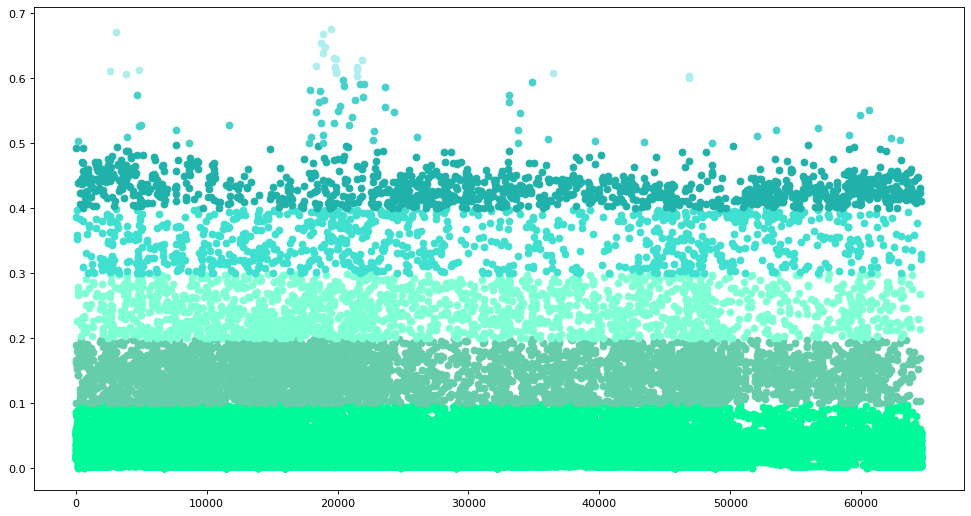

In [76]:
set1 = df[df['value'] < 0.1]
set2 = df[(df['value'] >= 0.1) & (df['value'] < 0.2)]
set3 = df[(df['value'] >= 0.2) & (df['value'] < 0.3)]
set4 = df[(df['value'] >= 0.3) & (df['value'] < 0.4)]
set5 = df[(df['value'] >= 0.4) & (df['value'] < 0.5)]
set6 = df[(df['value'] >= 0.5) & (df['value'] < 0.6)]
set7 = df[df['value'] >= 0.6]

plt.figure(figsize=(15, 8), dpi=80)
plt.scatter(set1.index, set1['value'], c = ['mediumspringgreen'])
plt.scatter(set2.index, set2['value'], c = ['mediumaquamarine'])
plt.scatter(set3.index, set3['value'], c = ['aquamarine'])
plt.scatter(set4.index, set4['value'], c = ['turquoise'])
plt.scatter(set5.index, set5['value'], c = ['lightseagreen'])
plt.scatter(set6.index, set6['value'], c = ['mediumturquoise'])
plt.scatter(set7.index, set7['value'], c = ['paleturquoise'])